In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

In [2]:
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pymc3 as pm

from rvhmc.data import RVDataset
from rvhmc.rvhmc import RVModel, RVPlanet
from rvhmc.estimator import lomb_scargle_estimator

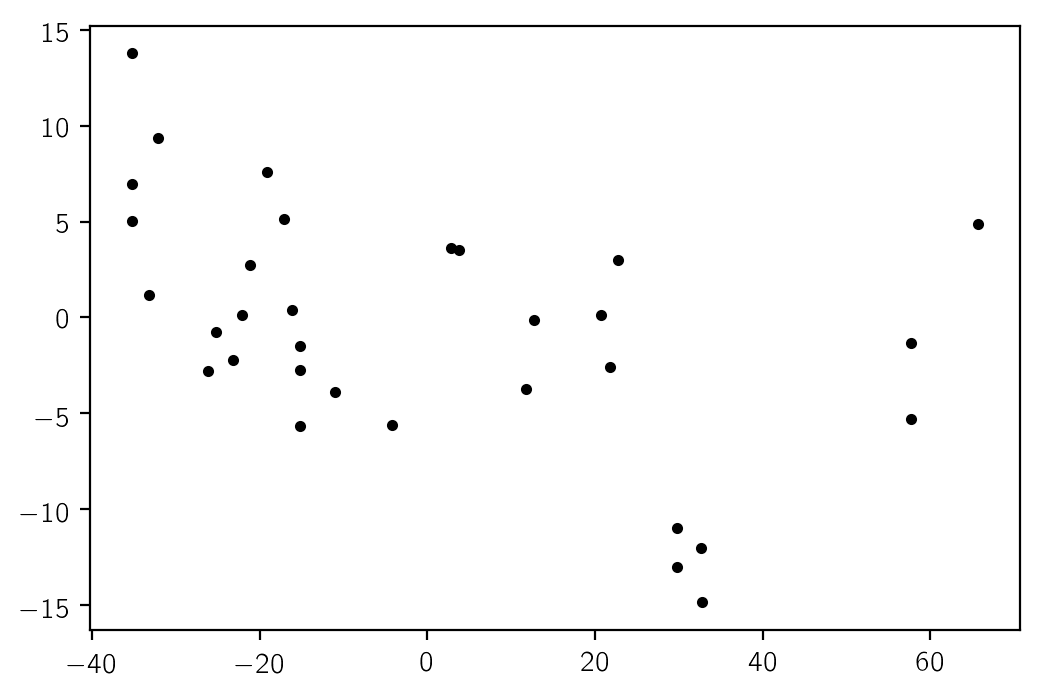

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv",
                 index_col=0)
t = np.array(df.t, dtype=float)
t -= np.mean(t)
y = np.array(df.vel, dtype=float)
yerr = np.array(df.errvel, dtype=float)
plt.plot(t, y, ".k");

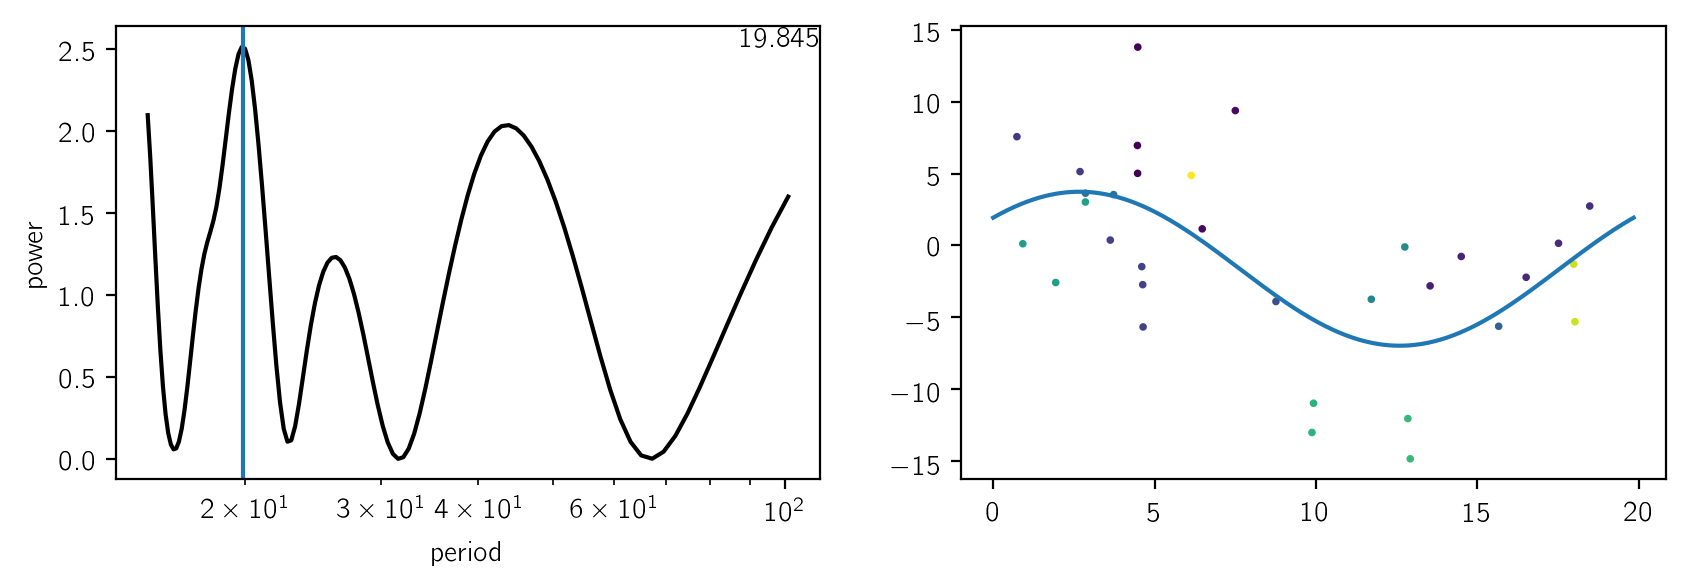

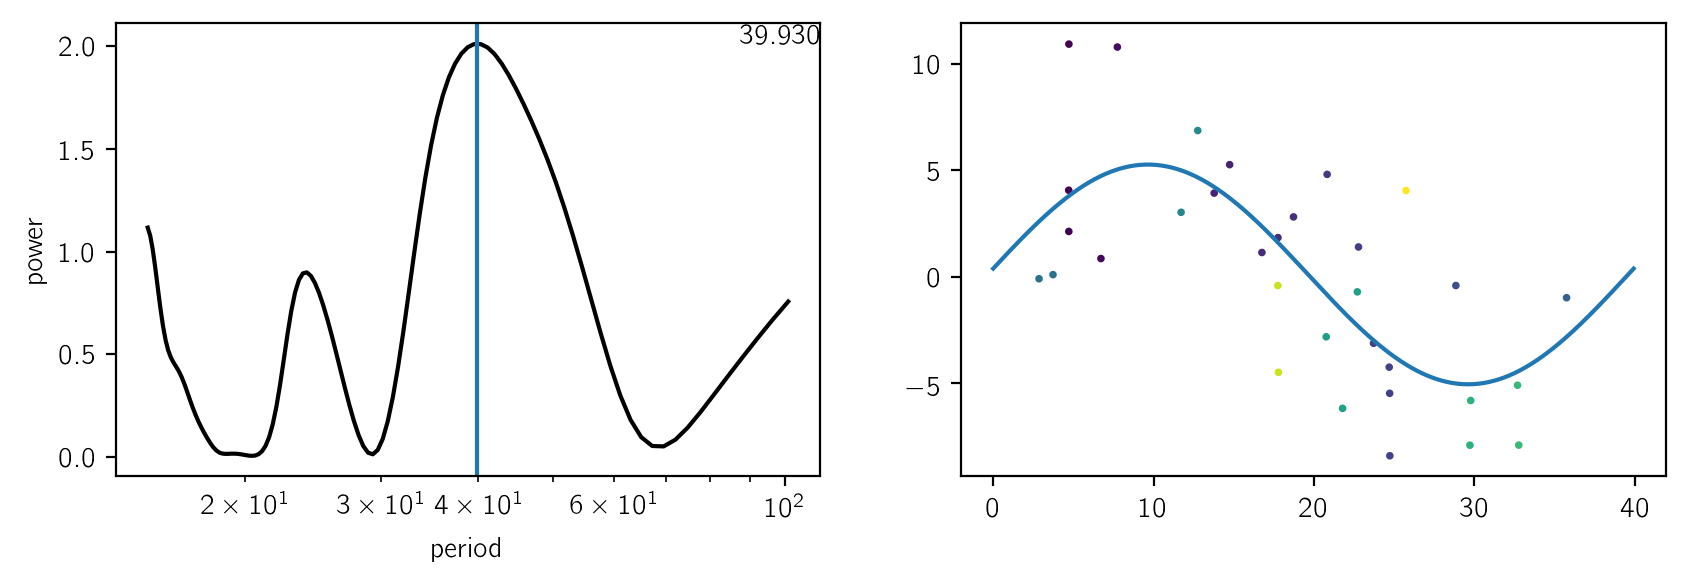

In [4]:
min_period = 15.0
max_period = (t.max() - t.min())
min_amp = 0.5*np.min(yerr)
max_amp = y.max() - y.min()

y0 = np.array(y)
peaks = []
for i in range(2):
    m = lomb_scargle_estimator(t, y0, yerr, max_period=max_period, min_period=min_period, max_peaks=1, samples_per_peak=20)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1.semilogx(1.0/m["periodogram"][0], m["periodogram"][1], "k")

    for peak in m["peaks"]:
        ax1.axvline(peak["period"])
    ax1.set_xlabel("period")
    ax1.set_ylabel("power")

    peak = dict(m["peaks"][0])
    A = np.vstack([
        np.sin(2*np.pi*t/peak["period"]),
        np.cos(2*np.pi*t/peak["period"]),
        np.ones_like(t),
    ]).T
    w = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, y0))
    x = np.linspace(0, peak["period"], 500)
    Am = np.vstack([
        np.sin(2*np.pi*x/peak["period"]),
        np.cos(2*np.pi*x/peak["period"]),
        np.ones_like(x),
    ]).T
    model = np.dot(Am, w)
    peak["amp"] = 0.5*(model.max() - model.min())
    peak["phase"] = np.arctan2(w[1], w[0])

    ax2.scatter(t % peak["period"], y0, c=t, s=3)
    ax2.plot(x, model)

    ax1.annotate("{0:.3f}".format(peak["period"]), xy=(1, 1),
                 xycoords="axes fraction", ha="right", va="top")
    
    y0 -= np.dot(A, w)
    
    peaks.append(peak)

In [9]:
with pm.Model() as model:
    data = RVDataset("data", t, y, yerr)
    
    planets = []
    for peak, name in zip(peaks, string.ascii_lowercase[1:]):
        planets.append(
            RVPlanet(
                name,
                pm.Uniform(name + ":logP", np.log(min_period), np.log(max_period),
                           testval=np.log(peak["period"])),
                pm.Uniform(name + ":logK", np.log(min_amp), np.log(max_amp),
                           testval=np.log(np.clip(peak["amp"], min_amp+1e-2, max_amp-1e-2))),
                eccen=pm.Uniform(name + ":eccen", 0, 1)
            ))
    
    RVModel("rv", data, planets)
    
#     print(model.test_point)
#     res = None
#     res = pm.find_MAP(res, vars=[p.phivec for p in planets])
#     for i in range(3):
#         vars = [v for p in planets for v in p.vars if v is not p.logP]
#         print(vars)
#         res = pm.find_MAP(res, vars=vars)
#         res = pm.find_MAP(res, vars=[v for p in planets for v in (p.logP, p.logK)])
#     for i in range(3):
#         res = pm.find_MAP(res, vars=[v for p in planets for v in p.vars])
#     res = pm.find_MAP(res, vars=[v for p in planets for v in (p.logP, p.logK)])

    trace = pm.sample(2000, tune=2000, start=res)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c:omegavec_unit, c:phivec_unit, c:eccen, c:logK, c:logP, b:omegavec_unit, b:phivec_unit, b:eccen, b:logK, b:logP]
Sampling 2 chains: 100%|██████████| 8000/8000 [03:08<00:00, 19.95draws/s]
There were 175 divergences after tuning. Increase `target_accept` or reparameterize.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [1]:
pm.traceplot(trace);

NameError: name 'pm' is not defined

In [ ]:
trace